In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

## MNIST data set

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
type(mnist)

sklearn.utils.Bunch

In [6]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

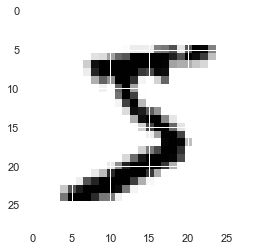

In [7]:
digit = X[0]
plt.imshow(digit.reshape(28, 28), cmap='binary');

In [8]:
y[0]

'5'

In [9]:
y = y.astype(int)

### Figure 3-1. Sample digits from the MNIST data set

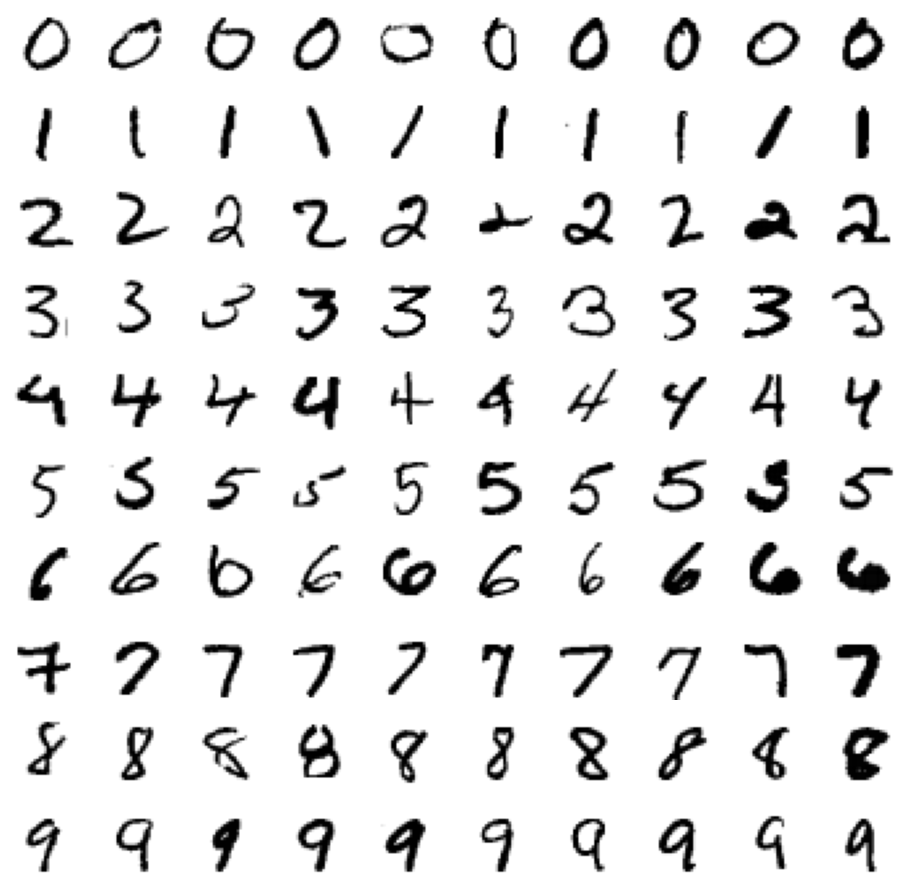

In [19]:
rng = np.random.default_rng(42)

fig, axs = plt.subplots(10, 10, figsize=(16, 16), sharex=True, sharey=True)
for i in range(10):
    X_new = X[y == i]
    selected = rng.choice(X_new, size=10, replace=False)
    for j in range(10):
        axs[i, j].imshow(selected[j].reshape(28, 28), cmap='binary')
        axs[i, j].axis('off')

In [20]:
split = 60000
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
X_train.shape, y_test.shape

((60000, 784), (10000,))

### Binary classifier to detect 5

In [25]:
from sklearn.linear_model import SGDClassifier

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5) # only classify 5's from others
sgd_clf.predict([digit]) # True if digit is 5, else False

array([ True])

In [26]:
from sklearn.model_selection import cross_val_score

scores_5 = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')
scores_5

#### Confusion matrix

NOTE: below, confusion_matrix from cross_val_predict is more accurate than the confusion_matrix from the full training set.
cross_val_predict divides the training data into folds and makes predictions for validation fold by learning ONLY from training fold. 
This way when predictions are made using cross_val_predict, the estimator doesn't learn from a sample before making a prediction for the same sample. This avoids overfitting to the training data?

In [39]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [41]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [38]:
confusion_matrix(y_train_5, sgd_clf.predict(X_train))

array([[52316,  2263],
       [  601,  4820]], dtype=int64)

#### precision & recall

In a binary classification setting:
1. recall is the fraction of the positives the model is able to predict. Also known as sensitiviy, true positive rate (TPR).
    - tp / (tp + fn)
2. precision is the fraction of correct positive predictions. 
    - tp / (tp + fp)
3. specificity is the fraction of correct negative predictions.
    - tn / (tn + fp)

#### precision-recall tradeoff

In [42]:
from sklearn.metrics import plot_precision_recall_curve

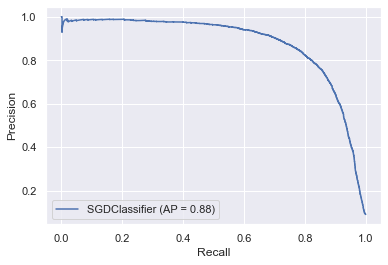

In [47]:
disp = plot_precision_recall_curve(sgd_clf, X_train, y_train_5, response_method='decision_function')

In [48]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                             method='decision_function') # use decision_function (instead of predict) to return scores

print(y_scores[:5])
print(y_train_pred[:5])
# scores above 0 are classified as positive class, else negative class

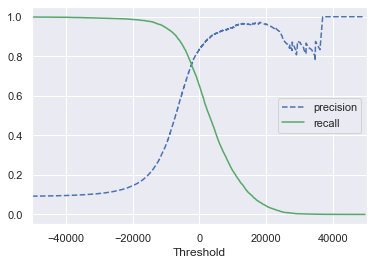

In [53]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train_5, y_scores)
print(len(precision), len(recall), len(threshold)) # p & r one more than t
plt.plot(threshold, precision[:-1], 'b--', label='precision')
plt.plot(threshold, recall[:-1], 'g-', label='recall')
plt.xlabel('Threshold')
plt.legend()
plt.xlim([-50000, 50000])
plt.show();

In [54]:
from sklearn.metrics import precision_score, recall_score

# scores at default threshold of 0
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


NOTE that pr curves from full training set are more optimistic than from cross-validation. The pr curve from cross-validation is more accurate representation of the models ability to generalize well for unseen data. 

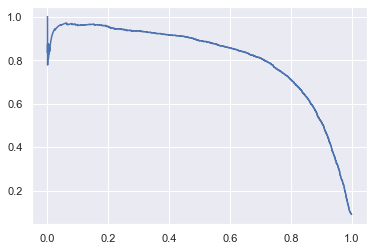

In [64]:
plt.plot(recall[:-1], precision[:-1]);

#### can we make our own precision-recall curves?

60000 60000 60000


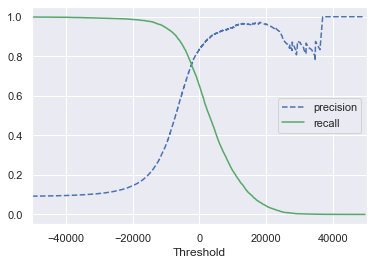

In [56]:
def my_pr_curve(labels, scores):
    my_p, my_r, my_t = [], [], []
    sorted_scores = np.sort(scores)
    for thresh in sorted_scores:
        preds = (scores >= thresh)
        tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
        my_p.append(tp / (tp + fp))
        my_r.append(tp / (tp + fn))
        my_t.append(thresh)
    return (my_p, my_r, my_t)

# my_p, my_r, my_t = my_pr_curve(y_train_5, y_scores)

# print(len(my_p), len(my_r), len(my_t))
# plt.plot(my_t, my_p, 'b--', label='precision')
# plt.plot(my_t, my_r, 'g-', label='recall')
# plt.xlabel('Threshold')
# plt.legend()
# plt.xlim([-50000, 50000])
# plt.savefig('./figures/3_clf/my_precision_recall_curve.png', dpi=200)
# plt.show();

Yes, we can make our own pr curve, but it is INSANELY slow compared to sklearn's pr curve. Below is the picture generated by 'my_pr_curve'

![title](./figures/3_clf/my_precision_recall_curve.png)

In [63]:
from sklearn.metrics import roc_curve, plot_roc_curve

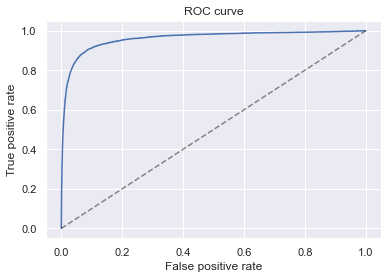

In [66]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show();

## Multiclass classification

Inherently, some classifiers are binary; others are multiclass.

Examples:
   - binary: SGD, SVM
   - multiclass: logistic, LDA, QDA, RandomForest, naive Bayes (NB), knn
   
However, sklearn allows using binary classifiers for multiclass classification. Internally, sklearn ovr or ovo strategies when using binary classifiers for multiclass classification task.

   - ovr (one-vs-rest): train one binary classifier for each class; choose the class with maximum score.
   - ovo (one-vs-one): train a binary classifier for each pair of classes; choose the class that wins most duels.
   
sklearn automatically chooses either ovr or ovo based on the model and training data. 
we can explicitly control which of the two strategies (ovr or ovo) is used by OneVsRestClassifier & OneVsOneClassifers

In [70]:
%%timeit -n 1 -r 1
# train a binary classifier (SGD) on multiclass
# sklearn automatically chooses either ovr or ovo strategy
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train) # NOT y_train_5
print(sgd_clf.predict([digit])) # true class is 5

[5]
312 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


#### ovr & ovo classifiers

However, we can specify the strategy explicitly. 

In [74]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

ovr_clf = OneVsRestClassifier(SGDClassifier())
ovo_clf = OneVsOneClassifier(SGDClassifier())

ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SGDClassifier())

In [75]:
len(ovr_clf.estimators_) # equal to n_classes

10

In [76]:
ovr_clf.decision_function([digit])

array([[-17807.74428883, -30863.00217343, -10256.49688147,
           352.49016424, -24675.69026048,   1277.58468421,
        -31207.05445739, -15777.64326764,  -6596.17961449,
         -7145.60469384]])

In [77]:
ovr_clf.estimators_[0].decision_function([digit])

array([-17807.74428883])

In [78]:
sgd_clf.decision_function([digit])

array([[-25577.6874583 , -34275.91613011, -12535.85045595,
         -2192.24465198, -17914.07837753,   3211.12666233,
        -20763.47058546, -10869.15549573,  -8208.50192404,
         -6565.32557154]])

In [79]:
ovo_clf.fit(X_train, y_train)
len(ovo_clf.estimators_)

45

In [80]:
ovo_clf.decision_function([digit])

array([[1.66666692, 4.66666707, 6.33333277, 8.3333332 , 0.66666685,
        9.33333319, 0.66666684, 3.66666892, 3.33333249, 6.33333252]])

In [81]:
ovo_clf.predict([digit])

array([5])

In [84]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

# scale training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# let's fit a few models
sgd_clf = SGDClassifier()
svm_clf = SVC()
log_clf = LogisticRegression()
lda_clf = LinearDiscriminantAnalysis()
qda_clf = QuadraticDiscriminantAnalysis()
knn_clf = KNeighborsClassifier()

%time sgd_scores = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')
%time svm_scores = cross_val_score(svm_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')
%time log_scores = cross_val_score(log_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')
%time lda_scores = cross_val_score(lda_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')
%time qda_scores = cross_val_score(qda_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')
%time knn_scores = cross_val_score(knn_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

C:\Users\jvenepal\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\jvenepal\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Wall time: 12min 38s
Wall time: 31min 14s


C:\Users\jvenepal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\jvenepal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logist

Wall time: 30.6 s
Wall time: 28.4 s


C:\Users\jvenepal\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\jvenepal\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\jvenepal\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Wall time: 41.5 s
Wall time: 55min 45s


In [86]:
print(sgd_scores.mean(), sgd_scores.std())
print(svm_scores.mean(), svm_scores.std())
print(log_scores.mean(), log_scores.std())
print(lda_scores.mean(), lda_scores.std())
print(qda_scores.mean(), qda_scores.std())
print(knn_scores.mean(), knn_scores.std())

0.9007333333333333 0.007053879941012768
0.9602666666666666 0.000573488351136155
0.9080333333333334 0.0016744816776808513
0.33349999999999996 0.28691871090374477
0.5289833333333335 0.009337766804160881
0.9403666666666667 0.002027039439401452


### Error analysis

In [100]:
# sgd_clf = SGDClassifier()
# sgd_clf.fit(X_train_scaled, y_train)

y_train_pred = sgd_clf.predict(X_train_scaled);

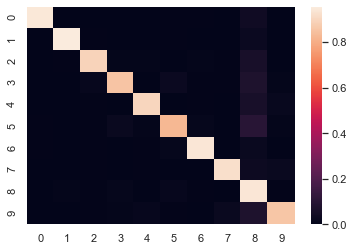

In [110]:
sns.heatmap(confusion_matrix(y_train, y_train_pred, normalize='true'), annot=False);

In [111]:
confusion_matrix(y_train, y_train_pred, normalize='true').round(2)

array([[0.94, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  ],
       [0.  , 0.95, 0.01, 0.  , 0.  , 0.01, 0.  , 0.  , 0.03, 0.  ],
       [0.  , 0.  , 0.89, 0.01, 0.01, 0.  , 0.01, 0.01, 0.06, 0.  ],
       [0.  , 0.  , 0.02, 0.86, 0.  , 0.03, 0.  , 0.01, 0.08, 0.01],
       [0.  , 0.  , 0.01, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.06, 0.02],
       [0.  , 0.  , 0.  , 0.02, 0.01, 0.83, 0.01, 0.  , 0.1 , 0.01],
       [0.  , 0.  , 0.01, 0.  , 0.01, 0.01, 0.94, 0.  , 0.03, 0.  ],
       [0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.  , 0.92, 0.03, 0.02],
       [0.  , 0.01, 0.01, 0.01, 0.  , 0.02, 0.  , 0.  , 0.94, 0.01],
       [0.  , 0.  , 0.  , 0.01, 0.02, 0.  , 0.  , 0.03, 0.07, 0.86]])

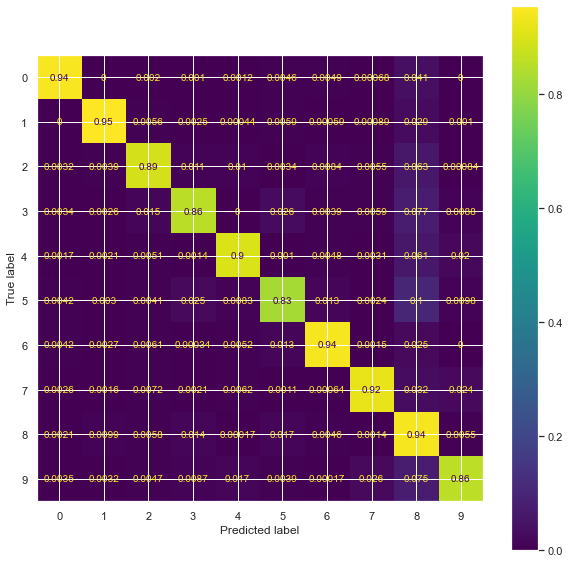

In [108]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_confusion_matrix(sgd_clf, X_train_scaled, y_train, normalize='true', ax=ax);
# ugh, that looks ugly!!